In [18]:
%matplotlib widget

from pathlib import Path
import numpy as np
import flammkuchen as fl
import pandas as pd

from matplotlib import  pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(style="ticks", palette="deep")
cols = sns.color_palette()
import ipywidgets as widgets

from lotr.utils import zscore
from lotr.pca import pca_and_phase, get_fictive_heading, fictive_heading_and_fit, \
        fit_phase_neurons
from circle_fit import hyper_fit
from lotr.experiment_class import LotrExperiment
from lotr import DATASET_LOCATION

import lotr.plotting as pltltr
COLS = pltltr.COLS
from lotr.utils import interpolate, roll_columns_jit, zscore

In [19]:
def nan_phase_jumps(phase_array):
    out_array = phase_array.copy()
    out_array[1:][np.abs(np.diff(out_array)) > np.pi] = np.nan
    return out_array

In [20]:
path = DATASET_LOCATION.parent / "2p data for zenodo" / "2p_HDN" / "211006_f1_cl"
traces = fl.load(path / "filtered_traces.h5", "/detr")
reg_df = fl.load(path / "motor_regressors.h5")
cc_motor = reg_df["all_bias_abs"].values
cc_motor_integr = reg_df["all_bias_abs_dfdt"].values
coords = fl.load(path / "data_from_suite2p_unfiltered.h5", "/coords")
anat = fl.load(path / "data_from_suite2p_unfiltered.h5", "/anatomy_stack")
traces[np.isnan(traces)] = 0

df = fl.load(path / "bouts_df.h5")
exp = LotrExperiment(path)
fn = int(exp.fn)
beh_df = exp.behavior_log

t_start_s = 50
t_lims = (t_start_s*exp.fn, exp.n_pts - t_start_s*exp.fn)
t_slice = slice(*t_lims)

In [21]:
selected = fl.load(path / "selected.h5")
pca_scores, angles, _, _ = pca_and_phase(traces[t_slice, selected].T, traces[t_slice, selected].T)
pcaed, phase, _, _ = pca_and_phase(traces[t_slice, selected], traces[:, selected])

In [22]:
unwrapped_phase = np.unwrap(phase)
traj, params = fictive_heading_and_fit(unwrapped_phase, df, min_bias=0.1)

exp = LotrExperiment(path)
coords = exp.coords_um[selected, 1:]

sort_idxs = np.argsort(exp.rpc_angles)
phase_shifts = (exp.network_phase / (2 * np.pi)) * (exp.n_hdns - 1)

meta NOT subset; don't know how to subset; dropped


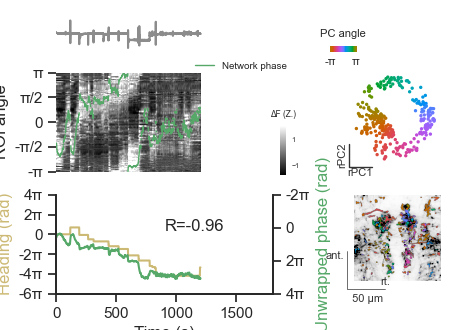

In [25]:
##### generating a summary figure 
anatomy_max = 200
xlim1 = 0
xlim2 = 1800

fig_sum, ax_sum = plt.subplots(3, 2, figsize=(4.5,3.3), gridspec_kw={'width_ratios': [2, 1], 'height_ratios': [1,3,3]})

t_beh = np.asarray(beh_df["t"])
t_beh[-1]
ax_sum[0,0].plot(t_beh, beh_df["tail_sum"], color=cols[7], label='Tail', rasterized=True)
ax_sum[0,0].legend(loc=2, bbox_to_anchor=(0.8, 2), fontsize=7)
ax_sum[0, 0].set_aspect('auto')
ax_sum[0, 0].set_xlim(xlim1, xlim2)

sc = ax_sum[1,1].scatter(pca_scores[:, 0], pca_scores[:, 1], c=angles, cmap=COLS["phase"], s=2)
pltltr.add_scalebar(ax_sum[1,1], xlabel="rPC1", ylabel="rPC2", xlen=30, ylen=30)
pltltr.add_cbar(
    sc,
    ax_sum[0, 1],
    inset_loc=(0.0, 0.15, 0.25, 0.2),
    ticks=[-np.pi + 0.1, np.pi - 0.3],
    ticklabels=["-π", "π"],
    title="PC angle",
    titlesize=8,
    orientation="horizontal",
)
ax_sum[1,1].axis("equal")


for i in range(3):
    ax_sum[i,1].axis('off')
ax_sum[0,0].axis('off')

anatomy = exp.anatomy_stack
colored_rois = exp.color_rois_by(angles, indexes=selected, color_scheme=COLS["phase"])
ax_sum[2, 1].imshow(anatomy[0], extent=exp.plane_ext_um, origin="upper", cmap='gray_r', vmax=anatomy_max)
ax_sum[2, 1].imshow(colored_rois.max(0), extent=exp.plane_ext_um, origin="upper", alpha=1)
pltltr.add_anatomy_scalebar(ax_sum[2,1], pos=(-10,-10))

N_BINS_RESAMPLED = 100
resampling_base = np.linspace(-np.pi, np.pi, N_BINS_RESAMPLED)
angle_resampled_traces = np.zeros((exp.n_pts, N_BINS_RESAMPLED))
for i in range(exp.n_pts):
    angle_resampled_traces[i, :] = np.interp(
        resampling_base,
        exp.rpc_angles[sort_idxs],
        exp.traces[i, exp.hdn_indexes[sort_idxs]],
    )

phase_shifts_resamp = (exp.network_phase / (2 * np.pi)) * (N_BINS_RESAMPLED - 1)
shifted_traces_resamp = roll_columns_jit(
    angle_resampled_traces, -np.round(phase_shifts_resamp)
)

ax = ax_sum[1,0]
im = ax.imshow(
    angle_resampled_traces.T,
    extent=[0, exp.time_arr[-1], -np.pi, np.pi],
    aspect="auto",
    cmap=COLS["dff_plot"],
    vmin=-1.7,
    vmax=2.0,
)

pltltr.add_dff_cbar(
    im,
    ax,
    (1.07, 0.04, 0.03, 0.5),
    title="ΔF (Z.)",
    titlesize=6,
    labelsize=5,
    ticklabels=None,
)

pltltr.despine(ax, ["left", "right", "top", "bottom"])
ax.set(ylabel="ROI angle", **pltltr.get_pi_labels(0.5, ax="y"))

ax_sum[1,0].imshow(
    resampling_base[:, np.newaxis],
    extent=[-50, 0, -np.pi, np.pi],
    cmap=COLS["phase"],
    aspect="auto",
)

line = nan_phase_jumps(phase_shifts) + exp.n_hdns / 3
line = line - np.nanmin(line)
line /=(np.nanmax(line))
line *= np.pi * 2
line -= np.pi

t_line = np.arange(0, np.shape(line)[0]) / 3
ax.plot(t_line, line, lw=1, c=cols[2], label="Network phase")
ax.legend(loc=2, bbox_to_anchor=(0.6, 1.2), fontsize=7)
ax.set_xlim(xlim1, xlim2)

ax_head = ax_sum[2,0]
ax_phase = ax_head.twinx()

phase_plot = unwrapped_phase
traj_plot = traj

ax_phase.plot(np.arange(len(phase_plot)) / 3, phase_plot, c=cols[2])
ax_head.plot(np.arange(len(traj[:])) / 3, traj_plot, c=cols[8])

pltltr.despine(ax_head, ["top"])

ax_head.set(ylabel="Heading (rad)", **pltltr.get_pi_labels(0.5, ax="y", coefs=(-6, -4, -2, 0, 2, 4)))
ax_phase.set(ylabel="Unwrapped phase (rad)", **pltltr.get_pi_labels(0.5, ax="y", coefs=(-2, 0, 2, 4)))
ax_phase.invert_yaxis()
ax_head.set_xlabel('Time (s)')
ax_head.set_xlim(xlim1, xlim2)
ax_phase.set_xlim(xlim1, xlim2)

r_value= np.corrcoef(traj_plot, phase_plot)[0,1]
r_value = np.round(r_value, decimals=2)
ax_head.text(x=900, y=1, s="R=" + str(r_value))

ax_head.yaxis.label.set_color(cols[8])
ax_phase.yaxis.label.set_color(cols[2])
pltltr.despine(ax_head, ["top"])
pltltr.despine(ax_phase, ["top"])

plt.subplots_adjust(left=None, bottom=None, right=0.99, top=0.95, wspace=0.4, hspace=0.3)
pltltr.savefig(path / "fig4.pdf")